<a href="https://colab.research.google.com/github/Br-alexis73/Face_recognition/blob/master/Multiclass_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Faces: Using a CNN model to Classify Unseen Faces in the 'Labelled Faces in the Wild' Dataset

The 'Labelled Faces in the Wild' (LFW) data set is a collection of 13,233 images of celebrity faces collected from the web, with the individual in each image manually labelled. The dataset is designed for exploring, creating and testing image recognition algorithms.<br/>

In this notebook, we will be attempting to run an algorithm that can successfully identify faces in the dataset after having been trained on similar faces. We will also consider the limitations of this approach in terms of applying the algorithm to real-world data. <br/>

The notebook is structured as follows:

**1. Library Installation and Data Read-in** <br/>
Rudimentary data cleaning to ensure data is structured in intuitive data frames <br/>
**2. Exploratory Data Analysis (EDA)** <br/>
Data exploration, visualisations, and splitting the data into training/test/validation sets <br/>
**3. Evaluation Metric Decisions** <br/>
What is the most meaningful evaluation metric to use in this situation? <br/>
**4. Model Construction** <br/>
We discuss a number of candidate computer vision (CV) algorithms and assess the accuracy of CNN techniques on test data <br/>
**5. Results Analysis** <br/>
Discussion of results and their interpretations <br/>
**6. Conclusion and Next Steps** <br/>
A discussion of this approach, real-world applications, limitations, and possible future extensions

# 1. Library installation and data read-in

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lfw-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F26922%2F34595%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240326%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240326T212245Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D47188d89de02dbe96dc89ecd5ce5e106ddf6e6acfb7454f89936c492a01ed0f69356143c010f8976df34f7560270cd4c8f74b7f403a641e59211e7af91fea3c4532c7f36db0850b21286b3eaee3fd2c31d066582ea48b841c60cb36a71c8284276c776d8e709c7b66a6c1bdbdd615983115f17cb88a7a740450fb5394916fbca6ae942183990ed741556f64204257b2c8cdc55376fe9370f145cc326af39174d7bde2dd897404003691b872db22ecb097d35ad1fc725aa2ae5627975468ad33e8926bb9cdfbaa9368ba697b5bb6cc84752810bb7893a2e3143332f904770e79c59b812c1883d4134c4f9b924d62703c980914a0207610edccd82415474e1b13b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 117895655 bytes downloaded
Downloaded and uncompressed: lfw-dataset
Data source import complete.


In [ ]:
# general functions
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

dataset_path = "../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"

In [ ]:
# Data read-in and cleaning

lfw_allnames = pd.read_csv("../input/lfw-dataset/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("../input/lfw-dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("../input/lfw-dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("../input/lfw-dataset/pairs.csv")
# tidy pairs data:
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("../input/lfw-dataset/people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("../input/lfw-dataset/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("../input/lfw-dataset/peopleDevTrain.csv")

# 2. Exploratory Data Analysis (EDA)

In [ ]:
print("Summary:")
print("There are " +
      str(lfw_allnames.shape[0]) +
      " unique celebrities in the entire dataset, of whom " +
      str(sum(lfw_allnames.images > 1)) +
      " are represented by multiple images. The entire number of images available is " +
      str(sum(lfw_allnames.images)) +
      ". The most represented celebrity is " +
      str(lfw_allnames.iloc[lfw_allnames['images'].idxmax()][0]) +
      ", with " +
      str(max(lfw_allnames.images)) +
      " unique images in the dataset.")

Summary:
There are 5749 unique celebrities in the entire dataset, of whom 1680 are represented by multiple images. The entire number of images available is 13233. The most represented celebrity is George_W_Bush, with 530 unique images in the dataset.


It is useful to gain an understanding of how the data is structured before we begin building the model. Using (omitted) exploratory code and information provided in the LDW dataset, a summary of the available files follows below:

**lfw_allnames.csv**: a CSV containing two columns; name (a list of all names in the entire dataset) and images (the number of images available for the each name) <br/>
**matchpairsDevTest**: a random sample of 500 image pairs featuring the same individual, with columns for the name and the two image labels <br/>
**matchpairsDevTrain**: a random sample of 1100 image pairs featuring the same individual, with columns for the name and the image labels <br/>
**mismatchpairsDevTest**: a random sample of 500 image pairs featuring different individuals, with columns for both names and the two image labels <br/>
**mismatchpairsDevTrain**: a random sample of 1100 image pairs featuring different individuals, with columns for both names and the two image labels <br/>
**pairs.csv**: 6000 pairs of images, both matched and mismatched. Matched pair rows contain a name and two image files, while unmatched pair rows contain a name for each of the images. For further formating, these two sets of rows will be split into matched_pairs and unmatched_pairs data frames <br/>
**people.csv**: list of names and image counts, identical to lfw_allnames.csv once null values have been removed. Omit from further analysis <br/>
**peopleDevTest.csv**: 1711 individuals in the dataset designed for testing: columns for celebrity name and image count (zero overlap with peopleDevTrain.csv) <br/>
**peopleDevTrain.csv**: 4038 individuals in the dataset designed for training: columns for celebrity name and image count (zero overlap with peopleDevTest.csv) <br/>

In addition, we have a catalogue of deepfunneled LFW images, created by Gary B. Huang, Marwan Mattar, Honglak Lee, and Erik Learned-Miller (details [here](http://vis-www.cs.umass.edu/papers/nips2012_deep_congealing.pdf)). This is the most useful dataset created by the LFW team, as the images have been rotated and sized to ensure consistent alignment prior to analysis, leading to stronger results when image recognition algorithms are applied to the dataset.

### Data reshaping and train/test split

We need to define the objective more clearly before we create the train/test split. What are we trying to achieve with this project?<br/>

The flow of the project should be as follows: <br/>
1. Build a model on the training data that can predict the names associated with images <br/>
The training set should incorporate multiple images of some individuals, to equip the model with knowledge of how to deal with the same face in different situations
2. Test the model on new images and predict the identity <br/>
The test set needs to incorporate some individuals that we have seen in the training set (although not the same images) and some individuals that we haven't, to test the algorithm's accuracy

Therefore, we need to split the data into training and test data.

In [ ]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index",1)
lfw_test = lfw_test.reset_index().drop("index",1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

# both comprehensively non-empty - we are ok to procede.
# N.B. although we don't use this training/test split in the following model, this is the format of the data we
# would use in applying models to the full dataset

874
844


<ipython-input-56-071ffe1205ed>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  image_paths = image_paths.drop("images",1)
<ipython-input-56-071ffe1205ed>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lfw_train = lfw_train.reset_index().drop("index",1)
<ipython-input-56-071ffe1205ed>:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  lfw_test = lfw_test.reset_index().drop("index",1)


### Image format exploration

In [ ]:
# verify resolution of all images is consistent
widths = []
heights = []
files = image_paths.image_path
for file in files:
    path = "../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(file)
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

pd.DataFrame({'height':heights,'width':widths}).describe()

# all 250 x 250 resolution

,height,width
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0


### Further data exploration

One of the drawbacks of the LFW dataset is that if has significant class imbalance. This can be dealt with using selective sampling, but it is useful to get an indication of the scale of the imbalance:

<Axes: >

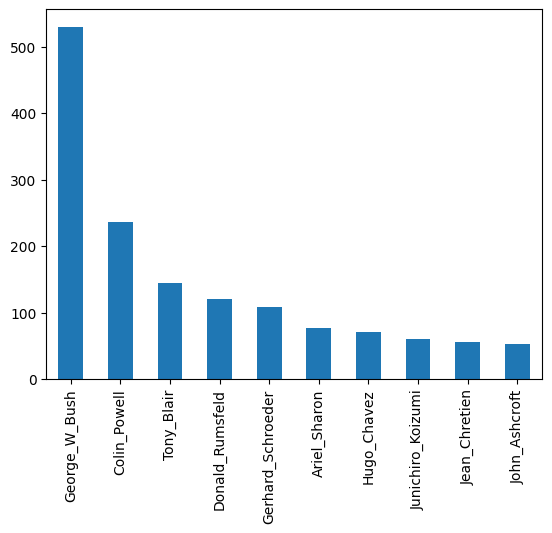

In [ ]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

We can see that there are some very well-represented figures among the top 10: generally political and generally male. This has important implications for the usefulness of this dataset in generalizations, which we consider in the conclusion. To draw this further into distinction, how many individuals are represented by a single image, compared to George W Bush's 530?

In [ ]:
ind_counts = image_paths.groupby('name').count().image_path
print(str(sum(ind_counts[ind_counts==1])) + " individuals, which is " + str(round(100*(sum(ind_counts[ind_counts==1])/sum(ind_counts)))) + "% of the total individuals considered, are only represented by a single image in this dataset.")

4069 individuals, which is 31% of the total individuals considered, are only represented by a single image in this dataset.


As a sanity check, and to check the directories are all correctly connected, we visualize a sample image:

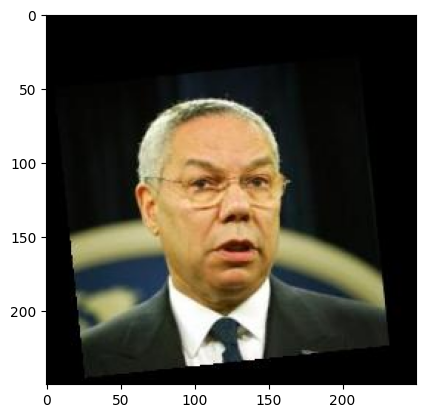

In [ ]:
im = Image.open("../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
plt.imshow(im)

# 3. Evaluation Metric Decisions
There is one final question to consider before building a model: what do we mean by accuracy? What constitutes a successful model?

**Accuracy** is defined as

$$ acc = {\frac{tp+tn}{n}} $$

Where *tp* is the number of true positive predictions, *tn* is the number of true negative predictions, and *n* is the total number of predictions. In other words, it is the proportion of all predictions that are correct. Accuracy is a useful indicator that our model performs well, but ignores the nuance that false positives and false negatives may have different costs associated with them. It also performs badly when there is a large class imbalance, which is a key consideration in the LFW dataset.

In the following models, we consider two key metrics: precision and recall. The **precision** of a model for predicted class x is defined as

$$ prec_{x} = {\frac{tp_{x}}{tp_{x}+fp_{x}}} $$

Where *fp*<sub>x</sub> is the number of false positive predictions for class x. In other words, precision represents the proportion of all images that are *predicted* to be in class x that *actually* belong to class x. The **recall** of a model for predicted class x is defined as

$$ rec_{x} = {\frac{tp_{x}}{tp_{x}+fn_{x}}} $$

Where *fn*<sub>x</sub> is the number of false negative predictions for class x. Recall indicates the proportion of all images that are *actually* in class x that are *predicted* to be in class x. It is also possible to combine precision and recall into an F1 score, but for the purposes of this notebook it is interesting to consider the real-world implications of the separate metrics.

Which of these metrics is likely to be more useful? A key consideration here is what this algorithm is likely to be used for in the real world, and the implications of different errors. Precision is useful when the cost of false positives is high. A classic example is in disease detection algorithms, where a false positive could lead to expensive further tests and emotional trauma for the recipient. On the other hand, recall is useful when the cost of false negatives is high. For example, if we were sifting through CCTV images to spot a wanted criminal and a model ignored an image where the criminal was present, this would constitute a fundamental problem with the model. In our setting, where image recognition is being utilized in the entertainment sphere, the key outputs are likely to be in image labelling for news services and video annotation for live broadcast. Both services are primarily interested in making sure any allocated labels are correct - missing labels are less problematic than incorrect labels, especially for building public trust in the system and avoiding embarrassing errors, so the cost of false positives is likely to be higher. Thus, while we still consider recall for each predicted class, we primarily focus on precision in our model results.

# 4. Model Construction
## 4. a. Preliminary Model: Detecting Faces
Any model concerned with classifying faces is posed with a preliminary problem: what is meant by a 'face'? This is obviously trivial for humans but identifying a face in an image is non-trivial for an image recognition algorithm. In the LFW data set, the data has been pre-processed to ensure that faces occupy a similar portion of each image, and that they are aligned consistently, with images rotated so the faces are square with the camera. Furthermore, the main CNN model we encode below considers the whole image, so implicitly recognises features of a face without us having to state where the face is. Thus, face detection is less important in this situation. However, in the real world - and particularly if we extend CNN analysis to videos - images are unlikely to be organised so helpfully, and this processing step is likely to be very important, hence its inclusion in this notebook. <br/>

To do this, we leverage previous work in the field. Facial detection is a well-researched area, and there are many potential methods to investigate and pre-trained models that perform well at identifying the region and features of a face. The model we focus on, MTCNN (Multitask Cascaded Convolutional Neural Networks) is optimised to identify the area of an image occupied by a face as well as the location of the eyes, nose, and mouth. The mechanics of this are detailed [here](http://arxiv.org/abs/1604.02878). At a high level, the model leverages three distinct deep convolutional layers to target and model the features of a face, with the layers constructed in a way that specifically addresses the challenges associated with facial images such as inconsistent orientation, shadows or obstructions, and inconsistent shapes between e.g. an open and closed mouth. <br/>

As well as strong performance evaluation on other face datasets, MTCNN has the added benefit of being very fast and very straightforward to implement, as is demonstrated in the below code cell:

1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 304ms/step


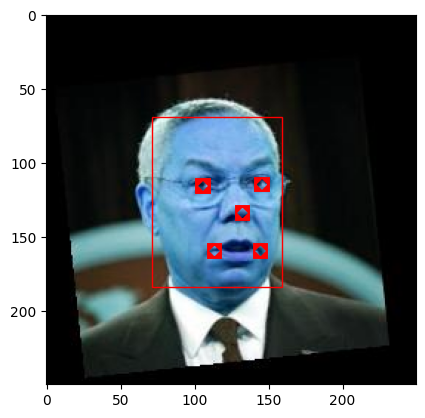

In [ ]:
# Use out-of-the-box MTCNN algorithm to identify facial boundaries on a sample image
detector = MTCNN()
image = cv2.imread("../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(lfw_train.image_path[0]))
result = detector.detect_faces(image)
# That's it - the results have already been generated! Now we extract the boundaries that have been identified
bounding_box = result[0]['box']
keypoints = result[0]['keypoints']

# Finally, we plot the image along with the face's bounding box and internal features (eyes, nose, and mouth corners)
fig,ax = plt.subplots(1)
ax.imshow(image)
# Create a Rectangle patch
rect = patches.Rectangle(bounding_box[0:2],bounding_box[2],bounding_box[3],linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
# Visualize all the internal features
for key in keypoints:
    rect_key = patches.Rectangle(keypoints[key],1,1,linewidth=10,edgecolor='r',facecolor='none')
    ax.add_patch(rect_key)
# Show the plots
plt.show()

We don't use these features in the main CNN models below, but they would be useful feature inputs for future models.

## 4. b. Classifying Faces: CNN Approach on a Simplified Dataset
In this Section we will implement a classic CNN algorithm on the LFW dataset. Before we build any models, it is important to understand the structure and purpose of a CNN. There is a wealth of literature available, but the main themes are briefly synthesised below.

A Convolutional Neural Network (CNN) is a neural network used primarily for image analysis. Its primary insight is that image regions can be scanned to obtain lower-dimensional "convolved" representations that preserve the relationships between pixel areas. There are 4 key steps in a CNN:

1. **Convolution**: convolve the images using a feature detector to obtain a feature map (e.g. edge detection)
2. **Non-Linearity**: create non-linearities in the data using a non-linear activation function
3. **Pooling**: reduce dimension of the feature maps further by considering average convolved values in a region
4. **Connect the layers**: organise all previous aspects of the model into a fully connected network that can be used to generate model predictions

The network is then trained using back-propagation.

![image.png](attachment:image.png)
Illustration of the layers of a CNN (image from "Effects of user-provided photos on hotel review helpfulness: An analytical approach with deep leaning" (2018))

Traditional CNN works best when the classes are balanced, and when the classification method is binary, i.e. we are testing to see whether the images are in category A or B. We can recreate these conditions on a subset of the data, using the most well-sampled individual: George W Bush. The goal of this first-pass CNN is to identify whether an image is George W Bush or not; we use a random sample of the other images for category B.

In [ ]:
not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_george])

In [ ]:
# withhold final test data
bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)
#  It is also useful to reserve a validation set in the training data, for use in the model construction
bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

In [ ]:
# initialize sequential network
from keras.models import Sequential
# include convolutional layers
from keras.layers import Conv2D
# Pooling layers
from keras.layers import MaxPooling2D
# flatten layers into single vector
from keras.layers import Flatten
from keras.layers import Dense

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


##Building a classifier Using the VGG in architecture

In [ ]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ZeroPadding2D, Activation

# def build_bush_classifier():
#     model = Sequential()

#     # Block 1
#     model.add(ZeroPadding2D((1,1), input_shape=(250, 250, 3)))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(64, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

#     #Block2
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(128, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

#     #Block3
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(256, (3, 3), activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(256, (3, 3), activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(256, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

#     #Block 4
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(512, (3, 3), activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(512, (3, 3), activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(512, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

#     # Block 5
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(512, (3, 3), activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(512, (3, 3), activation='relu'))
#     model.add(ZeroPadding2D((1,1)))
#     model.add(Conv2D(512, (3, 3), activation='relu'))
#     model.add(MaxPooling2D((2,2), strides=(2,2)))

#     # Custom Classifier Layers
#     model.add(Flatten())
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(4096, activation='relu'))
#     model.add(Dropout(0.5))
#     # Output layer for binary classification
#     model.add(Dense(1, activation='sigmoid'))

#     # Compile model
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#     return model

# # Now we build the model
# bush_classifier = build_bush_classifier()


##Building a Classifier using the AlexNet Architecture

In [ ]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# alexnet = Sequential()

# # Layer 1
# alexnet.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(227, 227, 3)))
# alexnet.add(BatchNormalization())
# alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# # Layer 2
# alexnet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"))
# alexnet.add(BatchNormalization())
# alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# # Layer 3
# alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"))
# alexnet.add(BatchNormalization())

# # Layer 4
# alexnet.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"))
# alexnet.add(BatchNormalization())

# # Layer 5
# alexnet.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"))
# alexnet.add(BatchNormalization())
# alexnet.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# # Layer 6
# alexnet.add(Flatten())
# alexnet.add(Dense(4096, activation='relu'))
# alexnet.add(Dropout(0.5))

# # Layer 7
# alexnet.add(Dense(4096, activation='relu'))
# alexnet.add(Dropout(0.5))

# # Layer 8 - Output layer for binary classification
# alexnet.add(Dense(1, activation='sigmoid'))

# # Compile the model
# alexnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



The model is now ready to run, but there is a final step required: the model will read training files from a dedicated training folder, so we need to make sure all the images are in folders with the correct labels.

In [ ]:
# define a custom function to move images to a new train/test/val directory

def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('/kaggle/working/',dir_name)):
            shutil.os.mkdir(os.path.join('/kaggle/working/',dir_name))

        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('/kaggle/working/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('/kaggle/working/',dir_name,data_type))
        path_from = os.path.join('../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/',image)
        path_to = os.path.join('/kaggle/working/',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1

    print('Moved {} images to {} folder.'.format(co,dir_name))

In [ ]:
# # move images:
# directory_mover(bush_train,"Bush_train/")
# directory_mover(bush_val,"Bush_val/")
# directory_mover(bush_test,"Bush_test/")


Now all the images are in the relevant training/test folders, we can run our CNN algorithm.

In [ ]:
# train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
# shear_range = 0.2,
# zoom_range = 0.2,
# horizontal_flip = True)
# test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
# Bush_training_set = train_datagen.flow_from_directory('/kaggle/working/Bush_train/',
#                                                  target_size = (250, 250),
#                                                  batch_size = 8,
#                                                  class_mode = 'binary')
# Bush_val_set = test_datagen.flow_from_directory('/kaggle/working/Bush_val/',
#                                             target_size = (250, 250),
#                                             batch_size = 8,
#                                             class_mode = 'binary')
# Bush_test_set = test_datagen.flow_from_directory('/kaggle/working/Bush_test/',
#                                             target_size = (250, 250),
#                                             batch_size = 8,
#                                             class_mode = 'binary')

In [ ]:
# Bush_history = bush_classifier.fit(Bush_training_set,
#                                              # set steps per epoch equal to the number of training images
#                                              steps_per_epoch = 10,
#                                              # there is a six hour runtime limit on Kaggle Kernels, restricting the maximum epoch number
#                                              epochs = 10,
#                                              validation_data = Bush_val_set,
#                                              validation_steps = 5)

Now that the model is operational, we can look at the relationship between the training and validation loss to see if overfitting is likely to have taken place:

In [ ]:
# bush_classifier.save("bush_classifier_model.h5")
# from keras.models import load_model

# # Load the saved model
# loaded_model = load_model("bush_classifier_model.h5")


In [ ]:
# # Create a figure and a set of subplots with 1 row and 2 columns
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# # Plot the accuracy on the first subplot
# ax1.plot(Bush_history.history['accuracy'])
# ax1.plot(Bush_history.history['val_accuracy'])
# ax1.set_title('Model Accuracy')
# ax1.set_ylabel('Accuracy')
# ax1.set_xlabel('Epoch')
# ax1.legend(['Train', 'Validation'], loc='upper left')

# # Plot the loss on the second subplot
# ax2.plot(Bush_history.history['loss'])
# ax2.plot(Bush_history.history['val_loss'])
# ax2.set_title('Model Loss')
# ax2.set_ylabel('Loss')
# ax2.set_xlabel('Epoch')
# ax2.legend(['Train', 'Validation'], loc='upper left')

# # Adjust the layout so that the subplots fit into the figure area.
# plt.tight_layout()

# # Display the plots
# plt.show()


Given the relatively low number of epochs, the model still appears to be converging - the validation loss/accuracy is instable, which is also a function of the validation method (in future iterations, cross validation would be a preferable method). However, accuracy is generally high on both sets, indicating that the model is performing well. To confirm the model's performance, we look at the precision and recall on the (unseen) test set, comparing accuracy with the true labels:

In [ ]:
# Alexnet_bush_history = alexnet.fit(Bush_training_set,
#                                              # set steps per epoch equal to the number of training images
#                                              steps_per_epoch = 20,
#                                              # there is a six hour runtime limit on Kaggle Kernels, restricting the maximum epoch number
#                                              epochs = 10,
#                                              validation_data = Bush_val_set,
#                                              validation_steps = 5)

In [ ]:
# alexnet.save("Alexnet_bush_classifier_model.h5")
# from keras.models import load_model

# # Load the saved model
# loaded_model = load_model("Alexnet_bush_classifier_model.h5")

In [ ]:
# # Create a figure and a set of subplots with 1 row and 2 columns
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# # Plot the accuracy on the first subplot
# ax1.plot(Alexnet_bush_history.history['accuracy'])
# ax1.plot(Alexnet_bush_history.history['val_accuracy'])
# ax1.set_title('Model Accuracy')
# ax1.set_ylabel('Accuracy')
# ax1.set_xlabel('Epoch')
# ax1.legend(['Train', 'Validation'], loc='upper left')

# # Plot the loss on the second subplot
# ax2.plot(Alexnet_bush_history.history['loss'])
# ax2.plot(Alexnet_bush_history.history['val_loss'])
# ax2.set_title('Model Loss')
# ax2.set_ylabel('Loss')
# ax2.set_xlabel('Epoch')
# ax2.legend(['Train', 'Validation'], loc='upper left')

# # Adjust the layout so that the subplots fit into the figure area.
# plt.tight_layout()

# # Display the plots
# plt.show()


In [ ]:
from keras.preprocessing import image

# create a function to predict class of images in a directory, given a trained classifier
def predictions(dir_name,classifier,binary):
    # dir_name should include name of predicted invididual - could edit this to iterate through folders in future
    predictions = []
    for im in os.listdir(dir_name):
        test_image = image.load_img(dir_name + str(im), target_size = (250,250))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        if(binary is True):
            result = float(str(classifier.predict(test_image))[2])
        else:
            result = np.argmax(classifier.predict(test_image))
        predictions.append(result)
    return(predictions)


In [ ]:
# # classes are passed through the algorithm in a random order - we want to retrieve the order of the classes
# Bush_test_names = []
# # collect all file names
# for i in range(len(Bush_test_set.filenames)):
#     Bush_test_names.append(Bush_test_set.filenames[i])
# # extract unique names, in order
# for i in range(len(Bush_test_names)):
#     Bush_test_names[i] = Bush_test_names[i].split("/")[0]
# Bush_test_name_order = list(OrderedDict.fromkeys(Bush_test_names))

In [ ]:
# # Compute predictions
# Bush_predictions_0 = predictions("/kaggle/working/Bush_test/"+ Bush_test_name_order[0] + "/",bush_classifier,binary = True)
# Bush_predictions_1 = predictions("/kaggle/working/Bush_test/"+ Bush_test_name_order[1] + "/",bush_classifier, binary = True)

# # Compare predictions to actual classes
# Bush_predictions_frame = pd.DataFrame(list(zip(Bush_predictions_0 + Bush_predictions_1,
#                                                 [0] * len(Bush_predictions_0) + [1] * len(Bush_predictions_1))),
#                                        columns = ['Predictions','Actual'])

In [ ]:
def prec_acc(predictions_frame):
    precision = []
    accuracy = []
    recall = []
    for i in range(len(set(predictions_frame['Predictions']))):
        tp = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] == i)].shape[0]
        tn = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] != i)].shape[0]
        fp = predictions_frame[np.logical_and(predictions_frame['Actual'] != i, predictions_frame['Predictions'] == i)].shape[0]
        fn = predictions_frame[np.logical_and(predictions_frame['Actual'] == i, predictions_frame['Predictions'] != i)].shape[0]
        total_preds = predictions_frame.shape[0]

        # Check if the denominator for precision is zero
        if (tp + fp) > 0:
            precision.append(tp / (tp + fp))
        else:
            precision.append(0)

        # Accuracy should not cause division by zero since total_preds should not be zero
        accuracy.append((tp + tn) / total_preds)

        # Check if the denominator for recall is zero
        if (tp + fn) > 0:
            recall.append(tp / (tp + fn))
        else:
            recall.append(0)

    return accuracy, precision, recall


In [ ]:
# Bush_accuracy = prec_acc(Bush_predictions_frame)
# print('Precision:' + str(Bush_accuracy[1]))
# print('Recall:' + str(Bush_accuracy[2]))
# print(Bush_test_name_order)

The meaning of these results will be considered further in the conclusion. Before proceding, we clear the workspace to ensure the Kernel can successfully run in the Kaggle infrastructure:

In [ ]:
# if "Bush_train" in os.listdir("./"):
#     shutil.rmtree("./Bush_train")
# if "Bush_val" in os.listdir("./"):
#     shutil.rmtree("./Bush_val")
# if "Bush_test" in os.listdir("./"):
#     shutil.rmtree("./Bush_test")


## 4. c. Classifying Faces: Multiple Classes Using a Classic CNN
The immediate logical extension of this problem is to extend analysis to multiple classes. With enough time, we could exactly replicate this approach on the entire dataset, using every identity as a separate class. However, given time constraints, we can consider a brief extension to explore the strengths and limitations of a simple CNN model. Instead of taking Bush and non-Bush images, we will take an arbitrary cut-off of the 6 most frequently occurring celebrities and attempt to classify the images.

In [ ]:
# obtain 6 most common celebrities

image_paths['name'].value_counts()[:10]

George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Junichiro_Koizumi     60
Jean_Chretien         55
John_Ashcroft         53
Name: name, dtype: int64

There is a clear issue with class imbalance here: to ensure more balanced classes, we could up-sample some of the low-representation individuals, but in the interests of algorithmic speed we will instead down-sample the high-representation individuals:

In [ ]:
multi_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(75),
                        image_paths[image_paths.name=="Colin_Powell"].sample(75),
                        image_paths[image_paths.name=="Tony_Blair"].sample(75),
                        image_paths[image_paths.name=="Donald_Rumsfeld"].sample(75),
                        image_paths[image_paths.name=="Gerhard_Schroeder"].sample(75),
                        image_paths[image_paths.name=="Ariel_Sharon"].sample(75)])

We then run the model as before, adjusting for multiple classes:

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ZeroPadding2D, Activation

# withhold final test data
multi_train, multi_test = train_test_split(multi_data, test_size=0.2)
# split into validation data
multi_train, multi_val = train_test_split(multi_train,test_size=0.2)

# Same model setup as before
multi_classifier = Sequential()

# Block 1
multi_classifier.add(ZeroPadding2D((1,1), input_shape=(250, 250, 3)))
multi_classifier.add(Conv2D(64, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(64, (3, 3), activation='relu'))
multi_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

#Block2
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(128, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(128, (3, 3), activation='relu'))
multi_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

#Block3
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(256, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(256, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(256, (3, 3), activation='relu'))
multi_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

#Block 4
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(512, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(512, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(512, (3, 3), activation='relu'))
multi_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

# Block 5
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(512, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(512, (3, 3), activation='relu'))
multi_classifier.add(ZeroPadding2D((1,1)))
multi_classifier.add(Conv2D(512, (3, 3), activation='relu'))
multi_classifier.add(MaxPooling2D((2,2), strides=(2,2)))

# Custom Classifier Layers
multi_classifier.add(Flatten())
multi_classifier.add(Dense(1024, activation='relu'))
multi_classifier.add(Dropout(0.5))
multi_classifier.add(Dense(1024, activation='relu'))
multi_classifier.add(Dropout(0.5))
# Output layer for categorical  classification
multi_classifier.add(Dense(6, activation='softmax'))

# Compile model
multi_classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
# move images to separate directories
directory_mover(multi_train,"train_multi/")
directory_mover(multi_val,"val_multi/")
directory_mover(multi_test,"test_multi/")

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
multi_training_set = train_datagen.flow_from_directory('/kaggle/working/train_multi/',
                                                 target_size = (250, 250),
                                                 batch_size = 8,
                                                 class_mode = 'categorical')
multi_val_set = test_datagen.flow_from_directory('/kaggle/working/val_multi/',
                                            target_size = (250, 250),
                                            batch_size = 8,
                                            class_mode = 'categorical')
multi_test_set = test_datagen.flow_from_directory('/kaggle/working/test_multi/',
                                            target_size = (250, 250),
                                            batch_size = 8,
                                            class_mode = 'categorical')

Moved 288 images to train_multi/ folder.
Moved 72 images to val_multi/ folder.
Moved 90 images to test_multi/ folder.
Found 473 images belonging to 6 classes.
Found 138 images belonging to 6 classes.
Found 168 images belonging to 6 classes.


In [ ]:
multi_history = multi_classifier.fit(multi_training_set,
                                               # set steps per epoch equal to the number of training images
                                               steps_per_epoch = 10,
                                               # as the data is smaller, we can run for more epochs
                                               epochs = 10,
                                               validation_data = multi_val_set,
                                               validation_steps = 2)

Epoch 1/10
10/10 [==============================] - 13s 475ms/step - loss: 1.8309 - accuracy: 0.1250 - val_loss: 1.7979 - val_accuracy: 0.1250
Epoch 2/10
10/10 [==============================] - 4s 321ms/step - loss: 1.7944 - accuracy: 0.1500 - val_loss: 1.7872 - val_accuracy: 0.3125
Epoch 3/10
10/10 [==============================] - 4s 433ms/step - loss: 1.7906 - accuracy: 0.2000 - val_loss: 1.7894 - val_accuracy: 0.1875
Epoch 4/10
10/10 [==============================] - 5s 511ms/step - loss: 1.7966 - accuracy: 0.1375 - val_loss: 1.7843 - val_accuracy: 0.1250
Epoch 5/10
10/10 [==============================] - 3s 334ms/step - loss: 1.7951 - accuracy: 0.1500 - val_loss: 1.8075 - val_accuracy: 0.0625
Epoch 6/10
10/10 [==============================] - 3s 252ms/step - loss: 1.7998 - accuracy: 0.1125 - val_loss: 1.7922 - val_accuracy: 0.1250
Epoch 7/10
10/10 [==============================] - 5s 524ms/step - loss: 1.7935 - accuracy: 0.1507 - val_loss: 1.7927 - val_accuracy: 0.2500
Epoch

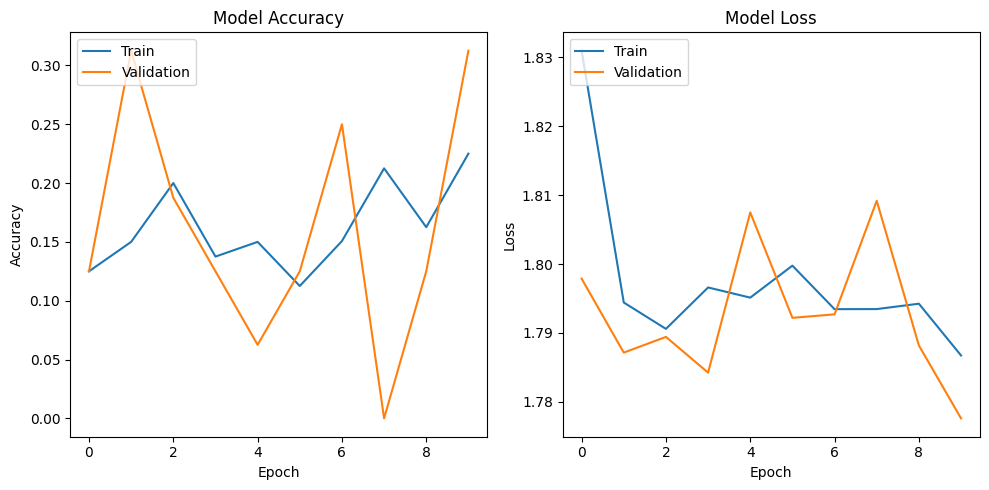

In [ ]:
# Create a figure and a set of subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the accuracy on the first subplot
ax1.plot(multi_history.history['accuracy'])
ax1.plot(multi_history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot the loss on the second subplot
ax2.plot(multi_history.history['loss'])
ax2.plot(multi_history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

# Adjust the layout so that the subplots fit into the figure area.
plt.tight_layout()

# Display the plots
plt.show()

Model loss appears broadly stable over 14 epochs; we do not seem to have reached the point of overfitting yet.

In [ ]:
# classes are passed through the algorithm in a random order - we want to retrieve the order of the classes
multi_test_names = []
# collect all file names
for i in range(len(multi_test_set.filenames)):
    multi_test_names.append(multi_test_set.filenames[i])
# extract unique names, in order
for i in range(len(multi_test_names)):
    multi_test_names[i] = multi_test_names[i].split("/")[0]
multi_test_name_order = list(OrderedDict.fromkeys(multi_test_names))

In [ ]:
multi_predictions_0 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[0] + "/",multi_classifier,binary=False)
multi_predictions_1 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[1] + "/",multi_classifier,binary=False)
multi_predictions_2 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[2] + "/",multi_classifier,binary=False)
multi_predictions_3 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[3] + "/",multi_classifier,binary=False)
multi_predictions_4 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[4] + "/",multi_classifier,binary=False)
multi_predictions_5 = predictions("/kaggle/working/test_multi/" + multi_test_name_order[5] + "/",multi_classifier,binary=False)


1/1 [==============================] - 0s 27ms/step


In [ ]:
multi_predictions_frame = pd.DataFrame(list(zip(multi_predictions_0 + multi_predictions_1 + multi_predictions_2 + multi_predictions_3 + multi_predictions_4 + multi_predictions_5,
                                                [0] * len(multi_predictions_0) + [1] * len(multi_predictions_1) + [2] * len(multi_predictions_2) + [3] * len(multi_predictions_3) + [4] * len(multi_predictions_4) + [5] * len(multi_predictions_5))),
                                       columns = ['Predictions','Actual'])

In [ ]:
multi_accuracy = prec_acc(multi_predictions_frame)
print('Precision:' + str(multi_accuracy[1]))
print('Recall:' + str(multi_accuracy[2]))
print(multi_test_name_order)

Precision:[0]
Recall:[0.0]
['Ariel_Sharon', 'Colin_Powell', 'Donald_Rumsfeld', 'George_W_Bush', 'Gerhard_Schroeder', 'Tony_Blair']


These results will be considered in Section 5. Again, we want to drop the used image directories to allow the Kernel to run:

In [ ]:
if "train_multi" in os.listdir("./"):
    shutil.rmtree("./train_multi")
if "val_multi" in os.listdir("./"):
    shutil.rmtree("./val_multi")
if "test_multi" in os.listdir("./"):
    shutil.rmtree("./test_multi")


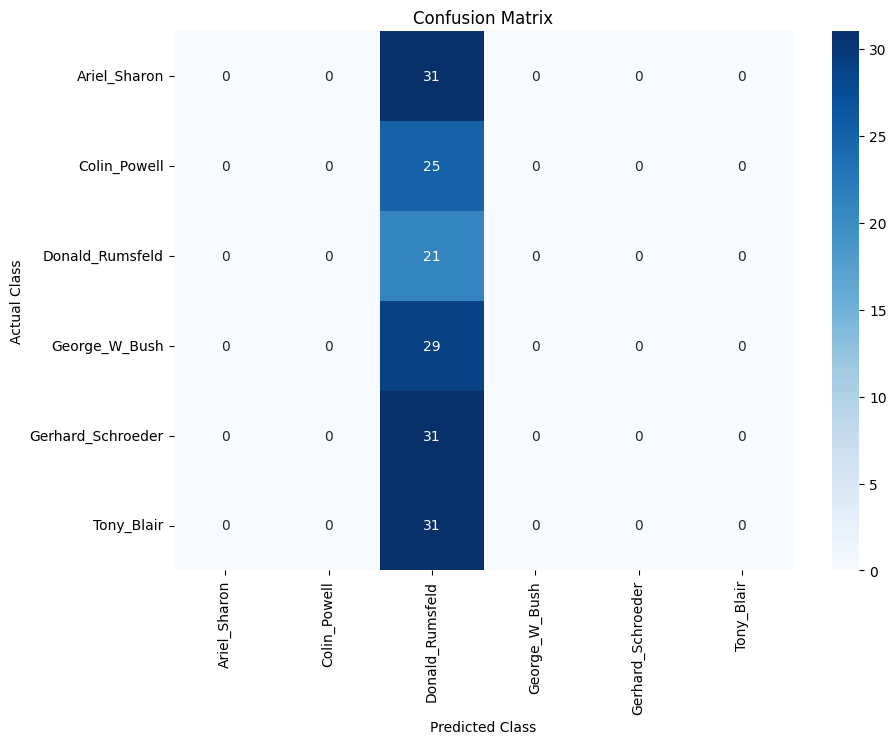

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming multi_predictions_frame already contains your model's predictions and the actual labels
# Convert predictions and actual values to numpy arrays if they aren't already
predictions = np.array(multi_predictions_frame['Predictions'])
actual = np.array(multi_predictions_frame['Actual'])

# Generate the confusion matrix
cm = confusion_matrix(actual, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=multi_test_name_order, yticklabels=multi_test_name_order)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


## 4. d. Classifying Faces: Advanced Models
The above is a useful demonstration of how CNN techniques can be applied to the facial recognition problem, but basic CNN is the tip of the iceberg. There are a range of much more sophisticated CNN-based image recognition algorithms; we will focus on two. **Faster R-CNN** uses a Region Proposal Network to identify objects and a second CNN algorithm to classify images. Its leveraging of deep convolutional networks and intelligent proposal of candidate regions means the algorithm is generally highly accurate and runs faster than other R-CNN algorithms - more information is available [here](http://arxiv.org/pdf/1506.01497.pdf).

However, "faster" is a relative term - if we are interested in real-time allocation, which (as previously discussed) could be very important in real-world occasions, then **YOLO** (you only look once) could be a useful alternative. The above CNN model takes around 0.1 seconds to make a prediction on a new image, which may be too slow for real-world applications such as frame-by-frame live video annotation, for instance for a news channel. YOLO algorithms speed up this computational time. The strength of YOLO is that it only looks at each image once, treating detection as more of a regression problem and thus allowing for computational speeds that allow the model to be leveraged in real-time applications. It also looks at the entire image rather than focusing on the pixels containing the object, thus encoding more contextual information in the model - this can be useful if the model is applied to different scenarios, such as representations of an object in different media formats (e.g. a painting of the object). More information on the workings of YOLO is available [here](http://https://arxiv.org/pdf/1506.02640v5.pdf).

The third extension that might boost speed and accuracy is to leverage previous results, and there are two ways we could do this. The first way would be to explore **out-of-the-box facial recognition algorithms**, such as the [face_recognition](http://github.com/ageitgey/face_recognition) tool built using dlib's face recognition system - this package has an accuracy of 99.38% on the LFW dataset. We don't explore this technique here for two reasons: firstly, implementing pre-built packages is not useful for learning new computer vision techniques, and secondly, the package is unavailable in a Kaggle Kernel environment. The second way is to impose a **transfer learning** structure on the algorithm. Certain features occur many times between different images - for example, a convolution that identifies edges may be useful across a range of domains. If we could optimise our model weights using the output of other models, such as VGG16, then we would expect to see improvements in accuracy and computational times. This technique could work particularly well in conjunction with the Faster R-CNN approach.

# 5. Results Analysis
On repeated runs of the George Bush model, we obtained a precision of around 81% and a recall of around 98%. In other words, 95% of the images we say are George Bush actually are George Bush, and 81% of the pictures of George Bush are identified as pictures George Bush. What does this mean in the real world?

As mentioned in Section 3, precision is the metric we are most interested in, and the value of around 81% indicates that only 19% of the images we say are George Bush are in fact someone else. Is this acceptable? It is likely the answer is no. In news labelling, it is likely that there would be a human on hand to QA results before they reach the public, but in live video labelling these errors are likely to be too prevalent to be useful and could lead to embarrassing mistakes. A recall rate of somewhere around 99.5%+, or <$\frac{5}{1000}$ errors of this nature, would give more confidence before committing this model to production. However, as discussed in Section 3, this very high recall value could give us confidence in applying this model to a different context where there is a high cost associated with false negatives.

How does accuracy look in the 6-individual model? Precision and recall are of similar volume but vary more between classes. Indeed, in the final model run before publishing this notebook, precision averaged around 0.8\* for all classes aside from one: the model's performance on Tony Blair images gave very low precision (0.41\*), as many of the Tony Blair test images were mis-classified as images of George W Bush. For the same reason, recall was low for the George W Bush class. Rather than being a slightly dated piece of satire, this indicates the potential drawbacks of a shallow network trained on low data volumes when tasked with identifying individuals who have similar demographics and tend to appear in similar pictures. This problem could be addressed by adding more complexity to the model.

\**final figures may vary due to differences in sampling and model initialization*

# 6. Conclusion and Next Steps
In this notebook, we have successfully run two CNN-based models using images from the LFW dataset: a two-class identifier that achieved precision of around 90% in 3 hours, and a six-class discriminator that achieved a similar precision in a much shorter time period (around 90 minutes) due to the lower data volumes. Thus, we have demonstrated that the CNN framework generalizes reasonably well to multiple classes, even when data volumes are relatively small, the CNN algorithm is simple, and the training time is low. However, there are several ways we could both improve the current model or extend to a different model that would likely bring higher accuracy and more reliable results.

### Future Model Improvements
The best way to improve the model is by implementing more sophisticated model extensions. As discussed in Section 4d, there are two key routes for this method: YOLO, if rapid implementation is required, or Faster R-CNN with transfer learning, if optimal model accuracy is key. Based on previous results in the CNN literature, either of these methods should give strong improvements in speed and accuracy.

Within the CNN infrastructure built in Section 4, there are several immediate improvements that we would make in future work, many of which are listed above: running for more epochs, on more classes, with more complex layers in the model. The first improvement would be in the model construction stage: the validation data is currently a single set, which with enough epochs can lead to overfitting on the validation data. Given the reasonable model performance on the test data, there doesn't seem to be a huge amount of overfitting, although it potentially manifests in the higher epochs of the six-class model. 10-fold cross validation would be preferable to a simple training/validation split.

Another important limitation around the model as it currently stands is its data input. As mentioned on the [LFW data source page](http://vis-www.cs.umass.edu/lfw/), there is large bias in the image selection around age, ethnicity and gender. Even after extending the model to encapsulate all the images, the utility of any trained model is always going to be hampered by this bias - predictions are only going to be accurate for the individuals represented in the dataset. A solution to this could be to incorporate more datasets in the training model, to increase its diversity and generalization (and therefore its impartiality). Some candidate datasets for this step are available at [http://www.face-rec.org/databases/](http://www.face-rec.org/databases/).

The final element to consider is the large class imbalance in the whole dataset. Up-sampling and down-sampling can be effective techniques when we have a small number of classes, or the class imbalance is small, but when the largest category has 500 times more images than the smallest then smarter tools are needed. This problem was considered in detail by the [Facebook AI Research Team](https://arxiv.org/pdf/1708.02002.pdf), who used focal loss (a weighted application of cross-entropy loss) to allocate "attention" to incorrect inferences. Exploring this loss function would be vital in obtaining an optimal model on the whole dataset.
